In [9]:
from models import unet_valid
from data_generator import batch_data_generator 
import matplotlib.pyplot as plt
import numpy as np

# from importlib import reload
# reload(data)
# reload(model)

In [10]:
# for Gunpowder
ZARR_FOLDER_TRAIN = '../../../../data/cells/raw/zarr/train/'
ZARR_FOLDER_TEST = '../../../../data/cells/raw/zarr/test/'
gp_batch_size= 1
gp_voxel_shape = [1,1,1]
gp_input_shape= [572, 572,4]
gp_output_shape = [ 388, 388,3]

# For unet
OUTPUT_PATH = '../../../../data/cells/models/'

unet_input_size = (572, 572,4)
unet_output_size = 3

In [11]:
from datetime import date

today = date.today()

d1 = today.strftime("%d_%m_%Y_")
base_name = d1+'unet_valid__mix_output'
model_name = base_name+'.hdf5'
model_name

'15_09_2020_unet_valid__mix_output.hdf5'

### Check data 

In [12]:
gen_train_fast = batch_data_generator(ZARR_FOLDER_TRAIN, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,
                                              output_shape = gp_output_shape,without_background=True )

gen_test_fast = batch_data_generator(ZARR_FOLDER_TEST, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,
                                             output_shape = gp_output_shape,without_background = True )

In [13]:
im,mask = next(gen_test_fast)
print(im.shape)
print(mask.shape)

Difference padding: 92
(1, 572, 572, 4)
(1, 388, 388, 3)


In [14]:
test_im = im[0]
test_mask = mask[0]
print(np.unique(test_mask))
print('Img size: {} {} < {} | Mask size: {} {} <{}'.format(test_im.shape,test_im.dtype,test_im.max()
                                                                   ,test_mask.shape,test_mask.dtype,test_mask.max()))

[0. 1.]
Img size: (572, 572, 4) float32 < 1.0 | Mask size: (388, 388, 3) float32 <1.0


In [15]:
# n = test_mask.argmax(axis=2)
# print(np.unique(n))
# plt.imshow(n)

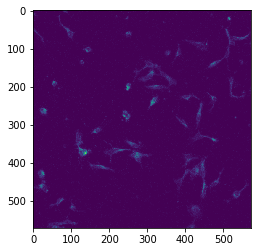

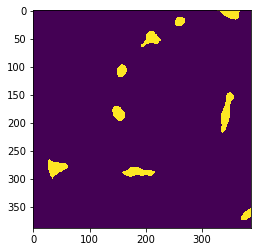

In [16]:
plt.imshow(test_im[:,:,2])
plt.show()
plt.imshow(test_mask[:,:,0])
plt.show()

### Model

In [17]:
unet_model = unet_valid(input_size = unet_input_size ,output_size = unet_output_size)

In [18]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Train

In [ ]:
import os
GRAPHS_FOLDER = '../../../../data/cells/graphs/'
GRAPH_NAME = os.path.join(GRAPHS_FOLDER,base_name+'.png')

from tensorflow import keras
import IPython.display as display
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.history = {}
        self.fig = plt.figure()
        
        self.logs = []
#         plt.show()

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        for l in logs:
            if l not in self.history:
                self.history[l]=[]
            self.history[l].append(logs.get(l))
        self.i += 1
        
        display.clear_output(wait=True)
        for l in logs:
            plt.plot(self.x, self.history[l], label=l)
        plt.legend()
        plt.savefig(GRAPH_NAME)
        plt.show();
        
plot_losses = PlotLosses()

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import os
# import PersonalizedCallbacks

model_file = os.path.join(OUTPUT_PATH,model_name)
# mean_io_u
model_checkpoint = ModelCheckpoint(model_file, monitor='val_loss',verbose=0, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [ ]:
# model_checkpoint,plot_losses
# 
history = unet_model.fit_generator(gen_train_fast,steps_per_epoch=30,
                                   validation_data = gen_test_fast,validation_steps=5,
                                   epochs=50,callbacks=[model_checkpoint],verbose=1)


Epoch 1/50
Difference padding: 92
30/30 [==============================] - 16s 524ms/step - loss: 0.0630 - accuracy: 0.3772 - mean_io_u: 0.4888 - val_loss: 0.0668 - val_accuracy: 0.0591 - val_mean_io_u: 0.4865
Epoch 2/50
30/30 [==============================] - 11s 371ms/step - loss: 0.0557 - accuracy: 0.0464 - mean_io_u: 0.4879 - val_loss: 0.0629 - val_accuracy: 0.0459 - val_mean_io_u: 0.4874
Epoch 3/50
30/30 [==============================] - 10s 340ms/step - loss: 0.0643 - accuracy: 0.0799 - mean_io_u: 0.4852 - val_loss: 0.0731 - val_accuracy: 0.0541 - val_mean_io_u: 0.4856
Epoch 4/50
30/30 [==============================] - 12s 386ms/step - loss: 0.0582 - accuracy: 0.0525 - mean_io_u: 0.4866 - val_loss: 0.0621 - val_accuracy: 0.0511 - val_mean_io_u: 0.4869
Epoch 5/50
30/30 [==============================] - 10s 323ms/step - loss: 0.0581 - accuracy: 0.0538 - mean_io_u: 0.4866 - val_loss: 0.0668 - val_accuracy: 0.0521 - val_mean_io_u: 0.4865
Epoch 6/50
30/30 [========================

### Test

In [ ]:
im,mask = next(gen_train_fast)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im[0][:,:,2])
# print(im[0])

In [ ]:
results = unet_model.predict(im)

In [ ]:
plt.imshow(results[3][:,:,1])

In [ ]:
import json
history2_file = os.path.join(OUTPUT_PATH,base_name+'.json')
history_v2_dict = history.history
json.dump(str(history_v2_dict), open(history2_file, 'w'))

In [ ]:
print(str(history_v2_dict))

In [ ]:
histoty